# Bericht Projektlabor Maschinelles Lernen (PML)

|Gruppenmitglied|Matrikelnummer|
|---|---|
|Christian Singer|2161064|
|Domenic Gosein|2160647|
|Lukas Burger|2150580|
|Maximilian Kürschner|2160331|

<p style="text-align: center;">Betreuender Dozent:<br>Dr.-Ing. Wei Yap Tan<br>Fakultät der Informationstechnik</p>
<p style="text-align: center;">Hochschule Mannheim<br>Wintersemester 2021/22</p>

## Inhalt

1. [Einleitung](#p1)
2. [Das Kalman Filter](#p2)
3. [1D Radarsensor Experiment](#p3)
4. [3D Radarsensor Experiment](#p4)
    1. [3D Radarsensor Experiment ohne DBScan](#p41)
    2. [Verschiede Parameter Werte beim 3D Experiment](#p42)  
    3. [Der DBScan Algorithmus](#p43)  
    4. [3D Radarsensor Experiment mit DBScan](#p44)
5. [Interaktiver Teil (Jupyter Notebook)](#p5)
    1. [Interaktives Kalman Filter 1D](#p51)
    2. [Interaktiver DBScan](#p52)
    3. [Interaktiver Kalman Filter mit DBScan 3D](#p53)
6. [Schlussfolgerung und Ausblick](#p6)
7. [Verwendete Literatur](#p7)
8. [Anhang](#p8)
    1. [GitHub Workflow](#p81)
    2. [Jupyter Notebook](#p82)

*Wenn Sie diesen Bericht mit Juypter Notebook ausführen, müssen Sie als erstes folgende Zeilen ausführen, um alle nötigen Module zu importieren.*

In [1]:
# Import aller benötigten Module

# Eigene Module
from DataGenerationRadar3D import *
from DBScan import *
from ui import interactive1DExperiment, interactiveDBScan, interactive3DExperiment

# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import *
from collections import deque
%matplotlib widget

## Einleitung <a name="p1"></a>

Nach einer Einführung in maschinelles Lernen, war es unsere Aufgabe das Kalman Filter und den DBSCAN Algorithmus für Daten aus einem 1D und anschließend 3D Radarsensor zu implementieren.

Um ein besseres Verständis für das Kalman Filter zu erlangen, haben wir uns zunächst mit der Theorie dahinter beschäftigt. Im Zuge dieses Prozesses sind wir auf den $\alpha$-$\beta$-Filter gestoßen. Der $\alpha$-$\beta$-Filter bildet die Grundlage für eine Reihe von Filtern, darunter auch das Kalman Filter. Wir haben uns daher dazu entschlossen, diesen zu Übungszwecken zu implementiert.

In [2]:
class abFilter:
    def __init__(self, x_0, dx, a, b, dt):
        self.x_est = x_0 # initial state value
        self.dx = dx # inital change rate
        self.a = a # a scale factor
        self.b = b # b scale factor
        self.dt = dt # time step
    
    def step(self, values):
        ests = []
        preds = []
        for z in values:
            # Predict
            x_pred = self.x_est + (self.dx * self.dt)
            preds.append(x_pred)
            self.dx = self.dx
            # Update
            residual = z - x_pred
            self.dx += self.b * (residual)/self.dt
            self.x_est = x_pred + self.a * residual
            ests.append(self.x_est)
        return np.array(ests), np.array(preds)

In unserem Beispiel verwenden wir den Filter dazu, das Körpergewicht einer Person vorherzusagen.

Unser Filter verwendet dazu folgende Parameter:
* `x_0` als initialen Zusatandswert (in unserem Fall das Anfangsgewicht)
* `dx` als initiale Änderungsrate des Gewichts z. B. +0.5 kg/Tag
* `a` als Faktor für die Veränderung der Gewichtsmessung
* `b` als Faktor für die Änderungsrate des Gewichts
* `dt` für das Zeitintervall

sowie `values` für unsere Messwerte.

Nachdem der $\alpha$-$\beta$-Filter initialisiert wurde, führt er folgende Schritte aus:

1. Berechnung der Vorhersage im nächsten Zeitintervall basierend auf aktuellem Schätzwert, Änderungsrate und Zeitintervall
2. Berechnen der Differenz aus aktuellem Messwert und Vorhersage
3. Anpassung der neuen Änderungsrate mit Faktor `b`, des Restwerts aus Schritt 2 und dem Zeitintervall
4. Berechnung des neuen Schätzwerts mittels Vorhersage, Faktor `a` und Restwert

Um den Filter zu testen haben wir mittels einer Funktion 14 Messwerte generiert und diese an den Filter übergeben. Zur Initialisierung haben wir zudem 86 kg, einen Änderungsrate von +1 kg/Tag, einen $\alpha$-Wert von 0.4 und einen $\beta$-Wert von 0.2 und einen Zeitintervall von 1 übergeben. Auf passende Werte für `a` und `b` sind wir durch ausprobieren gestoßen.

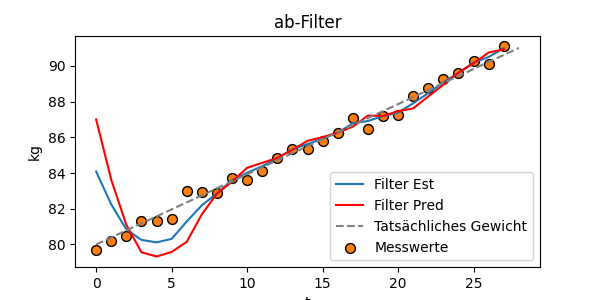

In [3]:
# Daten: Körpergewichte über n Tage verteilt gemessen
count = 28
def data_generator(x_0, dx, count, noise_factor):
    return [x_0 + dx * i + np.random.randn() * noise_factor for i in range(count)]

gewichte = data_generator(79.9, 0.4, count, 0.3) # kg
#print(gewichte)
zeitabstaende = [i for i in range(28)] # n Tage
print()
# Initialisierung und Ausführung des ab-Filters
gewicht_filter = abFilter(x_0=86, dx=1, a=0.4, b=0.2, dt=1.)
pr = gewicht_filter.step(values=gewichte)

# Ploten der Filter Ergebnisse im Vergleich zu den den echten Werten
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(pr[0], label='Filter Est')
ax.plot(pr[1], label='Filter Pred', color='r')
ax.scatter(zeitabstaende, gewichte, s=50, facecolor='C1', edgecolor='k', label='Messwerte')
ax.plot([0,count], [80., 91.], label='Tatsächliches Gewicht', linestyle='--', color='grey')
ax.set_xlabel('t')
ax.set_ylabel('kg')
ax.set_title("ab-Filter")
ax.legend()

Die von uns gewählte initiale Schätzung von 86 kg war mit Absicht sehr hoch gewählt. Wir sehen daher einen großen Ausschlag zu Beginn, schließlich benötigt der Filter einige Iterationen, um sein Werte anzupassen, so dass der Filter zum Ende hin eine deutlich bessere Schätzung ausgiebt.

## Das Kalman Filter <a name="p2"></a>

Das Kalman Filter ist ein Algorithmus, der anhand einer Reihe von Messungen über eine gewisse Zeit unbekannte Variablenwerte eines Systems schätzt. Dabei versucht das Filter Unsicherheiten durch statistisches Rauschen und den Einbezug eines zu Grunde liegenden physiklasichen Modells zu reduzieren.

In unserem Fall versuchen wir mit das Kalman Filter die Position eines Objekts erst im eindimensionalen Raum, dann in einem dreidimensionalen Raum vorherzusagen,. Die Messwerte liefert uns dabei eine Radarsensor Simulation.

Die Klasse `KalmanFilter` implementiert das Kalman Filter und besteht aus zwei Methoden. Über die `__init__(self, s_hat, transition_model, H, Q, R)` Methode kann das Kalman Filter mit folgenden Parametern initialisiert werden:
* `s_hat` ist die Position des Objekts im Raum (x, y, z Koordianten)
* `P_hat` ist die Kovarianz des Zustands
* `model/transition_model` ist das zu Grunde liegene physikalische Modell
* `H` ist die Messfunktion
* `Q` beschreibt das Prozessrauschen
* `R` beschreibt das Messrauschen

Nach der Initialisierung kann die `step(self,z)` Funktion mit den Messwerten `z` aufgerufen werden, um den Kalman Algorithmus auszuführen.

In [4]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
        self.kgain = []
    
    def step(self, z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T + self.Q
        # Calculate Kalman Gain
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        self.kgain.append(K)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        return self.s_hat

Im Detail führt die `step(self,z)` Methode dann folgende Schritte nacheinander aus:

1. Vorhersage der neuen Position
2. Berechnung der Kovarianz des Zustands
3. Berechung des Kalman Gain
4. Aktualisierung der Kovarianz des Zustands 
5. Verbesserung der Schätzung

Zum Schluss wird die neu geschätzte Position zurückgegeben.

## 1D Radarsensor Experiment <a name="p3"></a>

Die Simulation für den 1D Radarsensor gibt uns die Wahl zwischen fünf verschiedenen Bewegungsarten: Static, Constant Velocity, Constant Acceleration, Sinus und Triangle, sowie die Möglichkeit einen Sporadic Error zu den Sensordaten hinzuzufügen.
Zudem lassen sich an dieser Stelle die Sensor Eigenschaften anspassen.

In [5]:
## insert Lukas Teil hier

## 3D Radarsensor Experiment <a name="p4"></a>

Um die Ergebnisse und den Vorteil des DBScan Algorithmus zu verdeutlichen, haben wir das Experiment in zwei Abschnitte unterteilt. Im ersten Abschnitt betrachten wir die unterschiedlichen Ergebnisse des Experiments nur mit dem Kalman Filter, im zweiten Abschnitt dann mit vorgelagertem DBScan.

### 3D Radarsensor Experiment ohne DBScan <a name="p41"></a>

Um den Aufbau des Experiments zu zeigen, initialisieren wir an dieser Stelle zunächst einen Kalman Filter mit Werten, die sich durch unsere Experimente als gut erwiesen haben.

Unser **Übergangsmodell** ist wie folgt aufgebaut und basiert auf dem im Skript gegebenen pysikalischen Model der gleichmäßig beschleunigten Bewegung.

Bei einer *measurementRate* von *100 Hz* sieht dass zugrunde liegende Gleichungsystem demnach wie folgt aus:

$$
\begin{pmatrix}
1 & 0.01 & 0.01/2 \\
0 & 1 & 0.01 \\
0 & 1 & 0.01 \\
\end{pmatrix}
$$


In [6]:
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1,    0.01  ],
                             [0, 0,    0.01 ]])
print(transition_model)

[[1.    0.01  0.005]
 [0.    1.    0.01 ]
 [0.    0.    0.01 ]]


Mit der **Q-Matrix** fügen wir unser Prozessrauschen hinzu, in unserm Fall hat sich `0.05` als guter Wert für alle drei Parameter erwiesen:

In [7]:
Q = np.diag([0.09, 0.09, 0.09])
print(Q)

[[0.09 0.   0.  ]
 [0.   0.09 0.  ]
 [0.   0.   0.09]]


Durch Recherche (Quelle einfügen) sind wir darauf gestoßen, dass es eine gängie Methode ist die **R-Matrix** mit folgendem Wert für das Messrauschen des Radarsensor zu initialisieren: 

In [8]:
R = np.diag([rangeAccuracy**2])/3
print(R)

[[0.00083333]]


Zum Schluss initialisieren wir die **H-Matrix** wie folgt:

In [9]:
H =  np.array([[1., 0., 0.]])
print(H)

[[1. 0. 0.]]


Die Einstellungen für unser *Target* belassen wir bei den uns gegebenen Werten:

In [10]:
path = [[0,5,0],
        [0,5,0.5],
        [1,5,1],
        [1,5,0.5],
        [0.5, 2, 0.1]]

vel = 3 * numpy.ones((1,5))
vel[0,2] = 1

InitialPosition = numpy.array([-1,5,0])

opt = {
    'InitialPosition' : InitialPosition,
    'Path' : numpy.array(path).transpose(),
    'Velocities' : vel
}

x = Target(opt)

targets = [x]

Lediglich bei den Einstellungen des Radarsensors nehmen wir kleiner Anpassungen vor, um die *False Detections* zu reduzieren haben wir einen zusätzlichen Parameter zu den Optionen des 3D Radarsensors hinzugefügt. Der neue Parameter `falseDetectionsRange` bestimmt die *Range* der *False Detections* im *DataGenerationRadar3D* Skript.

In [11]:
optRadar = {
    'Position' : numpy.array([0,0,0.5]),
    'OpeningAngle' : numpy.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True,
    'falseDetectionsRange' : 10
}
sensor = RadarSensor(optRadar)

Anschließend iterieren wir mit nachfolgender Schleife über die *Detections* des 3D Radarsensors und plotten das Ergebnis:

In [12]:
Detections = np.array([0,0,0,0])
i = 0
pred = []

getNext = True
while(getNext == True):
    
    for target in targets:
        target.Step(1/sensor.opt['MeasurementRate'])
        getNext = getNext & ~target.reachedEnd  

    dets = sensor.Detect(targets)
    # Exclude radialVelocity for the moment. (todo: include it.)
    for det in dets:
        #det = det[:-1]
        Detections = np.vstack((det, Detections))
    
    s0 = np.vstack((Detections[0,:-1], np.zeros((2,3))))
    
    if i == 0:
        f = KalmanFilter(s0, transition_model, H, Q, R)
        pred.append(s0[0,:])
    
    s = Detections[0,:-1].reshape(1,3)
    s_hat = f.step(s)
    pred = np.vstack((s_hat[0,:], pred))
    i += 1

In den beiden Abbildungen sehen wir die *Predictions* des Kalman Filter getrennt von den *Detections* der Simulation:

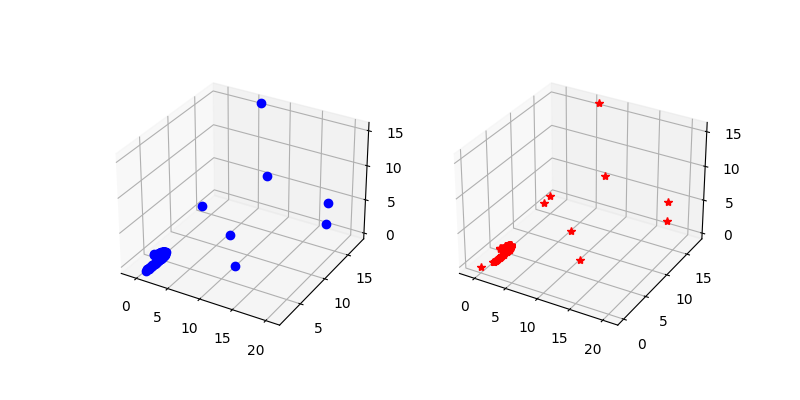

In [13]:
T1 = pred[:-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='3d')   
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
ax2.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

Legen wir beide zusammen erhalten wir folgenen Plot:

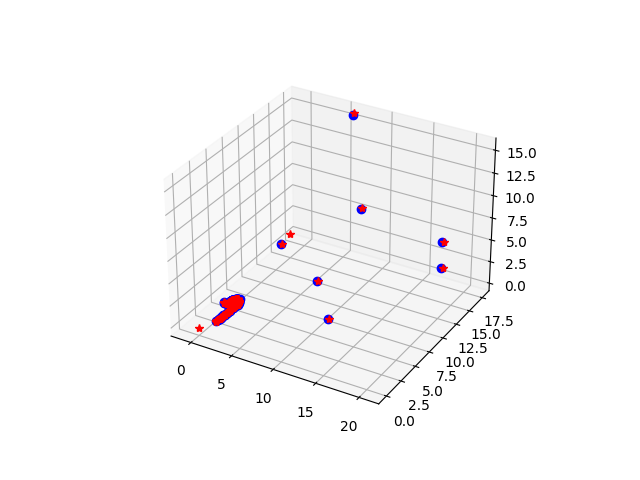

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
ax.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

In diesem zusammengefügten Plot können wir nun deutlich erkennen wir gut unser Kalman Filter mit seiner aktuellen Initialisierung die Posistion unseres Objekts vorhersagt.
Im folgenden werden wir die einzelnen Parameter des Kalman Filter verändern und das Ergebnis dabei untersuchen.

### Verschiede Parameter Werte beim 3D Experiment <a name="p42"></a>

Als estes verändern wir die **Q-Matrix**. Indem wir deren Werte erhöhen und damit mehr Rauschen zum Prozess hinzufügen.

```python
Q = np.diag([0.09, 0.09, 0.09])
```

![](figs/QMatrix-009-fig1.png)
![](figs/QMatrix-009-fig2.png)

Wie man sehen kann, führt dies zu..

Verändert man die **R-Matrix** wie folgt..

```python
R = 
```



Wie man sehen kann, führt dies zu..

### Der DBScan Algorithmus <a name="p43"></a>

Der DBSCAN Algorithmus findet vorhande Cluster in einer Menge an Datenpunkten. Um diese Aufgabe zu erfüllen hat der Algorithmus zwei verstellbare Parameter. Zum einen den Paramater `eps`, der bestimmt in welchem Radius um den Datenpunkt nach Nachbarn gesucht wird, und zum anderen den Parameter `minpts`, der festlegt wie viele Punkte es minimal braucht damit es sich um einen Kernobjekt handelt.\
Da sich die gefunden Cluster mit dem verstellen der Parameter ändern können müssen diese auf das jeweilige Problem angepasst werden.

Für den DBSCAN wurde eine Klasse erstellt, durch die der Algorithmus mit den beiden zuvor geannten Parametern initialisiert wird. Einmal initialisiert kann man den Algorithmus mit den gesetzten Parametern auf verschiedene Datensätze anwenden.

In [15]:
class DBSCAN():
    def __init__(self, eps=0.5, minpts=5):
        self.eps = eps
        self.minpts = minpts

Um die Cluster in einem bestimmten Datensatz zu finden besitzt die DBSCAN Klasse die Funktion `fit(self, X)`. Dabei entspricht `X` dem Datensatz der analysiert werden soll. Innerhalb dieser Funktion wird der DBSCAN Algorithmus auf die Daten aus `X` angewendet und die einzelnen Datenpunkte werden als Kernobjekte, Dichte-erreichbare Objekte und Rauschpunkte kategorisiert.\
Für die Bestimmung der Punkte Art wird der Abstand zwischen zwei Punkten benötigt. Um diesen Abstand zu bestimmen wird die Hilfsfunktion `pairwise_sq_distance` erstellt.

In [16]:
def pairwise_sq_distance(X1, X2):
    # Calculate the pairwise distance between all pairs of points from X1 and X2.
    return np.sum(X1**2, axis=1, keepdims=True) - 2*np.matmul(X1, X2.T) + np.sum(X2**2, axis=1, keepdims=True).T

In [17]:
def fit(self, X):
    dist = pairwise_sq_distance(X, X)
    neighbours = list(map(lambda d: np.arange(d.shape[0])[d < self.eps**2], dist))
    
    # Label all points as outliers initially.
    self.assignment = np.full((X.shape[0],), -1, dtype=int)
    # Find core points.
    # Determine the number of neighbors of each point.
    N_neighbors = np.sum(dist < self.eps**2, axis=1)
    self.assignment[N_neighbors >= self.minpts] = -2
    
    # Create clusters.
    cluster = 0
    stack = deque()
    for p in range(X.shape[0]):
        if self.assignment[p] != -2:
            continue
            
        self.assignment[p] = cluster
        
        stack.extend(neighbours[p])
        # Expand cluster outwards. 
        while len(stack) > 0:
            n = stack.pop()
            label = self.assignment[n]
            # If core point include all points in ε-neighborhood.
            if label == -2:
                stack.extend(neighbours[n])
            # If not core point (edge of cluster).
            if label < 0:
                self.assignment[n] = cluster
        
        cluster += 1

DBSCAN.fit = fit

Die Funktion `fit` findet die verschiedenen Cluster und speichert diese in der Variable `assignments` ab. Das heißt wenn ich die Methode `fit` aufrufe werden nicht die gefundenen Cluster zurückgegeben. Für diese Aktion existiert die `predict` Methode.\
Zusätzlich zu der basis `predict` Funktion gibt es auch die Methode `fit_predict`. Diese ruft zuerst `fit` auf, also findet die Cluster, und danach `predict`, also um die Werte zurückzugeben. Das heißt wenn man den Algorithmus zum ersten mal auf einen Datensatz anwendet und direkt das Ergebnis haben will sollte die Funktion `fit_predict` verwendet werden. Wenn man das Ergebnis des Algorithmus zu einem spätern Zeitpunkt nochmal benötigt muss nur noch `predict` ausgeführt werden. Kurz gesagt kann durch die Aufsplittung von `fit` und `predict` Rechenaufwand reduziert werden.

In [18]:
def predict(self,X):
    return self.assignment

def fit_predict(self, X):
    self.fit(X)
    return self.assignment

DBSCAN.predict = predict
DBSCAN.fit_predict = fit_predict

Um den DBSCAN zu testen haben wir den `make_moons` Datensatz von scikitlearn genutzt. Das Ergebnis kann man hier sehen:

Accuracy: 100.0%


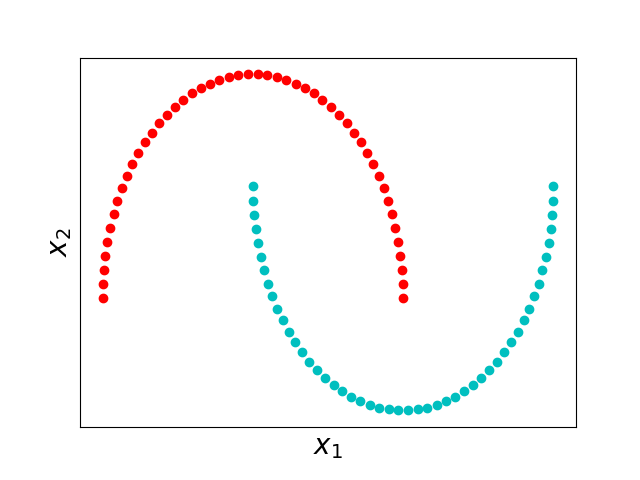

In [19]:
from sklearn.datasets import make_moons

X,y = make_moons(100)
model = DBSCAN()
preds = model.fit_predict(X)
# Either low or high values are good since DBSCAN might switch class labels.
print(f"Accuracy: {round((sum(preds == y)/len(preds))*100,2)}%")

fig= plt.figure(facecolor='w')
ax = plt.axes()
plt.plot(X[:, 0][preds==1], X[:, 1][preds==1], "co")
plt.plot(X[:, 0][preds==0], X[:, 1][preds==0], "ro")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)

# Simplifying the plot by removing the axis scales.
plt.xticks([])
plt.yticks([])

# Displaying the plot.
plt.show()

### 3D Radarsensor Experiment mit DBScan <a name="p44"></a>

In diesem Experiment sollen ein oder mehrere Ziele in einem drei dimensionalen Raum getrackt werden. Dafür werden der DBSCAN, zur Zielerkennung und der Kalman-Filter zur Laufbahnvorhersage genutzt.

In dem folgenden Code werden diese Ziele und ihre Laufbahnen angelegt:

In [20]:
# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}

# Parameters second target.
path2 = [[1. , 4. , 1. ],
         [1. , 5. , 1.7],
         [2. , 5. , 1. ],
         [3. , 4. , 2. ],
         [3. , 4. , 1.5],
         [2. , 4. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}

Zusätzlich wird der Radar Sensor initialisiert:

In [21]:
'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

Die Bewegung der Ziele findet in einer while-Schleife statt. Dabei wird in jeder Iteration jedes Ziel einen Schritt weiter bewegt. Nachdem ein Schritt durchgeführt wurde versucht der Sensor die Ziele wahrzunehmen und mithilfe des DBSCAN die Ziele zu finden. Die Analyse durch den DBSCAN gibt allerdings erst ab einer in `pt_history` festegelegt Anzahl an Datenpunkten einen Sinn.\
Sobald das erste mal diese Anzahl erreicht wurde wird der DBSCAN in jeder Iteration auf die letzten `pt_history` Datenpunkte angewendet. Die dabei gefundenen Cluster werden den verschiedenen Zielen aus `labeled` zugeordnet. Exisitiert das Ziel noch nicht in diesem Dictionary wird es erstellt.

In [22]:
def scan(model, pt_history, targets):
    getNext = True
    detections = np.array([0,0,0,0])
    # Count number of iterations
    i = 0
    labeled = {}

    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        for det in dets:
            detections = np.vstack((det, detections))

        if i >= pt_history:
            # First application of DBSCAN.
            clusters = model.fit_predict(detections[:pt_history])
            # Determine number of targets (objects tracked).
            num_objs = set(clusters)

            for j in num_objs:
                # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]

                if j not in labeled.keys():
                    labeled[j] = detections[obj_idx,:-1]

                s = detections[obj_idx,:-1].reshape(1,3)
                labeled[j] = np.vstack((s, labeled[j]))
                
    return labeled

Werden diese dann visualisiert kann man erkennen, dass einige Datenpunkte Ausreißer sind und der Rest Pfade verschiedener Objekte darstellen. Über das folgende Dictionary wird festgelegt welches Objekt welche Farbe bekommen soll (Es sind so viele, denn je nach Einstellung der Parameter werden mehr als die zwei Realen Objekte gefunden).

In [23]:
colors = { -1: 'red', 0: 'green', 1: 'yellow', 2: 'blue', 3: 'purple', 4: 'orange', 5: 'pink', 6: 'black', 7: 'brown' }

Um eine gute Einstellung für den DBSCAN zu finden werden zuerst zwei Extreme Einstellungen getestet. Bei der ersten (links) Einstellungen werden die Parameter niedrig und bei der zweiten Einstellung (rechts) hoch initialisiert. Dabei wird die Variable `pt_history` bei einem Wert von konstant 20 belassen (ein Erhöhen dieser Variable entspricht einem Verringern von `minpts` und ein Verringern der Variable entspricht einer Erhöhung von `minpts` (das kann im interaktiven Beispiel am Ende der Sektion überprüft werden)).

Found 6 clusters and 107 outlier!
Found 1 clusters and 107 outlier!


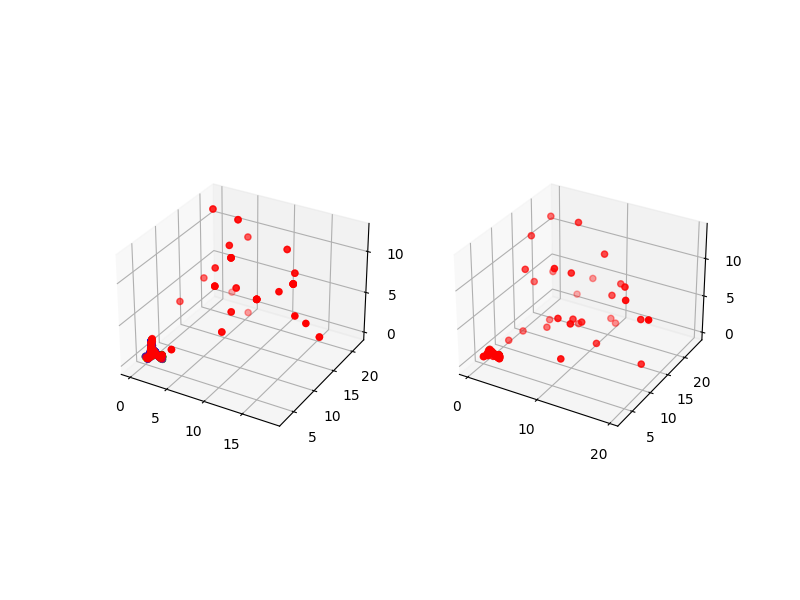

In [24]:
model1 = DBSCAN(eps=0.1, minpts=2)
model2 = DBSCAN(eps=1, minpts=10)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
labeled1 = scan(model1, pt_history, targets)
print(f'Found {len(labeled1.keys())-1} clusters and {len(labeled1[-1])} outlier!')

ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in labeled1.keys():
    T = labeled1[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   
    
    
# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

labeled2 = scan(model2, pt_history, targets)
print(f'Found {len(labeled2.keys())-1} clusters and {len(labeled2[-1])} outlier!')

# Plot Trajectories
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in labeled2.keys():
    T = labeled2[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

# show plot
plt.style.use('classic')
plt.show()

Das Ergebnis dieses Tests ist, das bei beiden Einstellungen etwas nicht stimmt. Bei der ersten zu niedrigen Einstellung werden zu viele Cluster gefunden. Das liegt vermutlich an einem zu niedrigen Wert für `eps`, denn dadurch werden nur die Punkte mit einer so geringen Entfernung einem Cluster zu geordnet => `eps` erhöhen. Ähnliches passiert bei der zweiten Einstellung. Bei dieser kann zwar Objekte in einem größeren Umkreis finden (was auch passiert), aber er braucht deutlich mehr `minPts` bevor diese zu einem Cluster zählen => `minPts` verringern. 

Ergebend aus unseren ersten beiden Tests ergibt sich das ein für uns gutes Ergebnis zwischen den beiden Extrema liegen muss. Also `eps` hoch und `minPts` runter (bei der Einstellung von `pt_history` = 20). Durch mehrere Tests der selben Art hat sich die folgende Einstellung für uns als gut ergeben.

Found 2 clusters and 94 outlier!


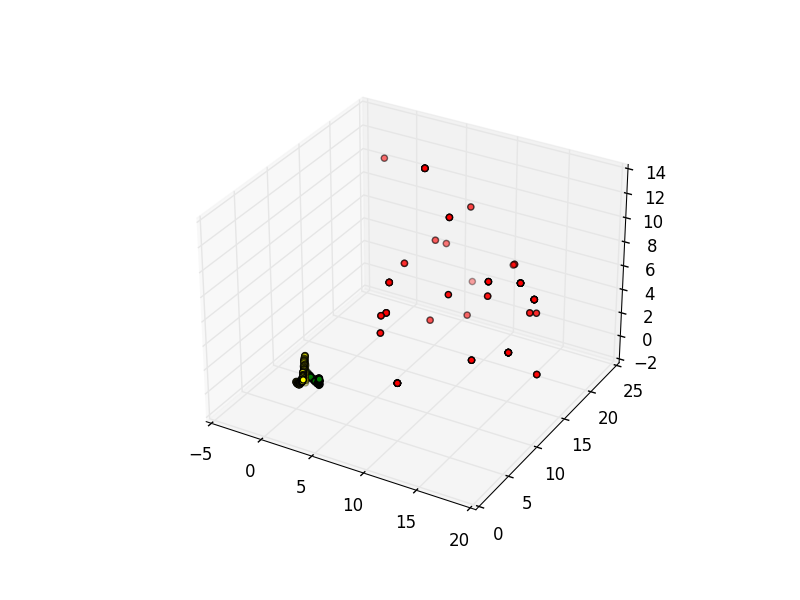

In [25]:
model = DBSCAN(eps=0.7, minpts=2)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

labeled = scan(model, pt_history, targets)
print(f'Found {len(labeled.keys())-1} clusters and {len(labeled[-1])} outlier!')

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
ax = plt.axes(projection='3d')   
for label in labeled.keys():
    T = labeled[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

# show plot
plt.show()

Wie zu sehen werden die beiden Objekte gut durch den DBSCAN erkannt und die Ausreißer erfolgreich rausgefiltert.

## Interaktiver Teil (Jupyter Notebook) <a name="p5"></a>

*Um diesen Teil nutzen zu können, muss das Jupyter Notebook im Browser ausgeführt werden*

### Interaktives Kalman Filter 1D <a name="p51"></a>

Im interaktiven Kalman Filter 1D können sämtliche Parameter des 1D Experiments angepasst werden und dadurch die unterschiedlichen Auswirkungen auf das Ergebnis beobachtet werden.

Output()

Output()

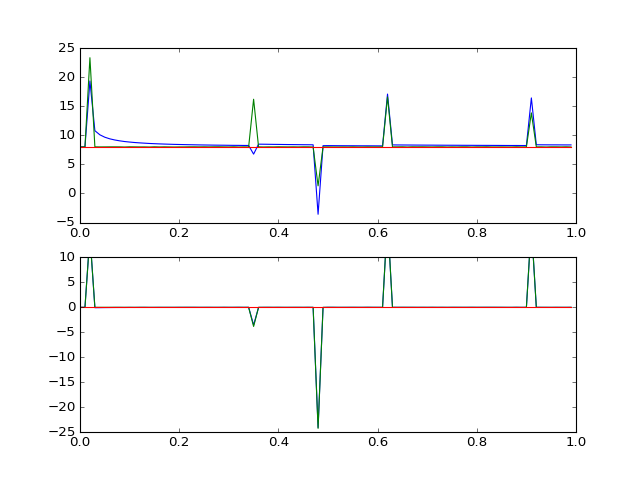

In [26]:
interactive1DExperiment.plot_interactive_kalaman_filter()

### Interaktiver DBScan <a name="p52"></a>

In dem folgenden Beispiel können die Parameter `eps`,`minPts` und `PT History` verstellt werden, um zu sehen, wie die verschiedenen Einstellungen das Ergebnis des DBScan beinflussen.

Output()

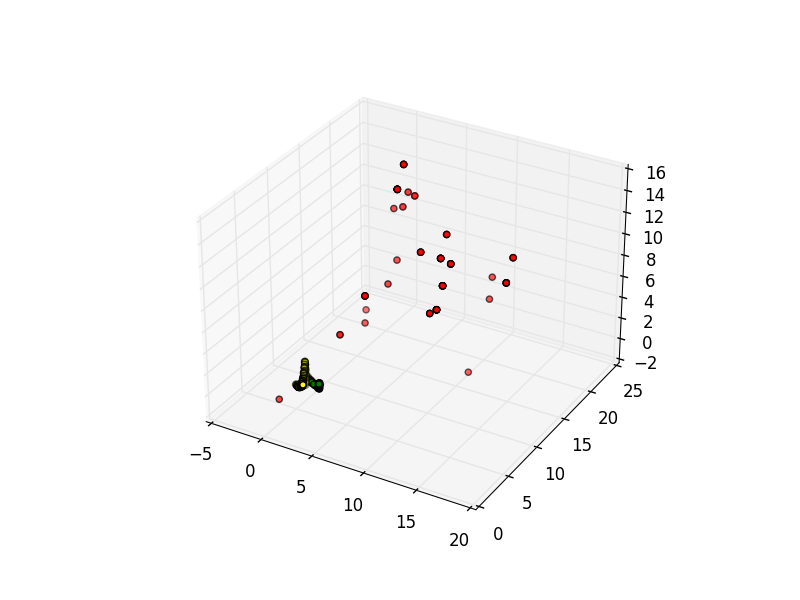

In [27]:
interactiveDBScan.plot_interactive_dbscan()

### Interaktiver Kalman Filter mit DBScan 3D <a name="p53"></a>

Im interaktiven Kalman Filter 3D können die Parameter des DBScan angepasst werden und dadurch die unterschiedlichen Auswirkungen auf das Ergebnis beobachtet werden. Zusätzlich können bis zu vier *Targets* gleichzeitg ausgewählt werden und für einzelne *Targets* können auch die *False Detections* angezeigt werden.
Der rote Punkt zeigt die Position des Radarsensors an.

Output()

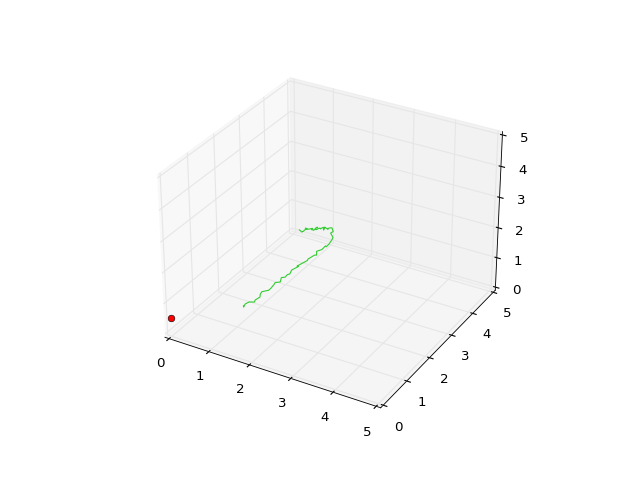

In [28]:
interactive3DExperiment.plot_3DExperiment()

## Schlussfolgerung und Ausblick <a name="p6"></a>

TEXT EINFÜGEN

## Verwendete Literatur <a name="p7"></a>

1. Kalman and Bayesian Filters in Python, 2015, Roger R. Labbe

## Anhang <a name="p8"></a>

## GitHub Workflow <a name="p81"></a>

Um den Code für unser Projekt zu verwalten haben wir ein privates GitHub Repository verwendet. Sofern die Berechtigung im Voraus erteilt wurde, ist das Repository unter folgendem Link erreichbar: https://github.com/otiofrui/pml

## Jupyter Notebook <a name="p82"></a>

Da sowohl das Kalman Filter, als auch der DBScan und die Radarsensor Simulation viele Einstellungsmöglichkeiten bieten, haben wir uns dafür entschieden unseren Bericht mit Hilfe eines Juypter Notebooks interaktiv zu gestalten. Dies ermöglicht es dem Leser die Parameter der Programme selbst anzupassen und das Ergbenis so zu beinflussen.